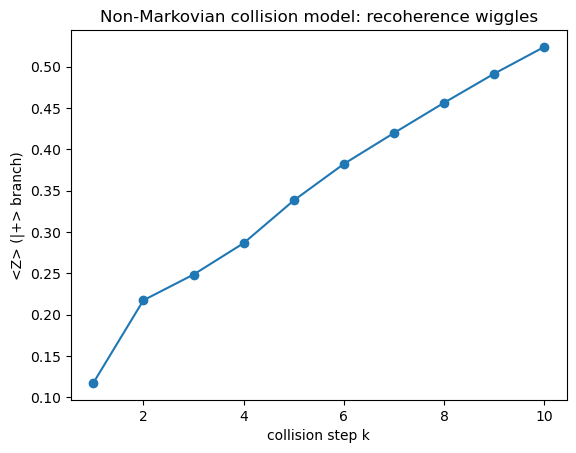

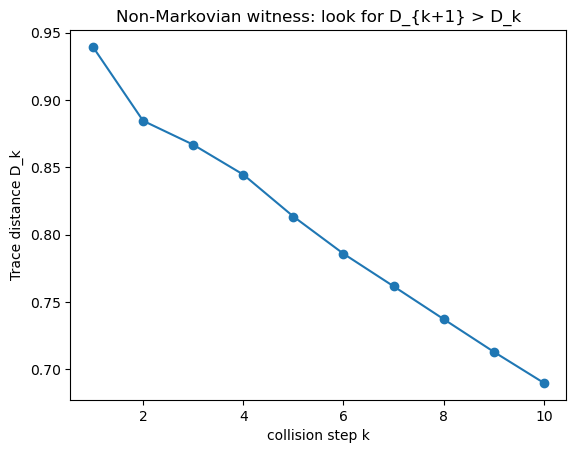

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, Pauli

# Model knobs
N_anc = 10             # number of ancillas (time steps)
theta = 0.35           # S<->A_k partial-swap strength per collision
phi   = 0.55           # A_k<->A_{k+1} coupling (seeds memory between steps)

# Build a single circuit that implements all steps and saves snapshots
def make_collision_circuit(init_state='+'):
    qr = QuantumRegister(1+N_anc, 'q')  # q[0]=system, q[1..N_anc]=ancillas
    qc = QuantumCircuit(qr, name=f"collisions_{init_state}")

    # Prepare system in |+> or |->; ancillas default to |0>
    qc.h(qr[0])
    if init_state == '-':
        qc.z(qr[0])    # |->

    # For each step k: collide S<->A_k, then correlate A_k<->A_{k+1}
    for k in range(N_anc):
        a_k = 1 + k
        # Collision (partial swap via XX + YY)
        qc.rxx(theta, qr[0], qr[a_k])
        qc.ryy(theta, qr[0], qr[a_k])

        # Correlate ancillas to create memory, except after last ancilla
        if k < N_anc - 1:
            a_k1 = 1 + k + 1
            qc.rxx(phi, qr[a_k], qr[a_k1])
            qc.ryy(phi, qr[a_k], qr[a_k1])

        # Save full density matrix after step k
        qc.save_density_matrix(label=f"rho_step_{k+1}")

    return qc

qc_plus  = make_collision_circuit(init_state='+')
qc_minus = make_collision_circuit(init_state='-')

backend = AerSimulator(method='density_matrix')
res1 = backend.run(qc_plus,  shots=1).result()
res2 = backend.run(qc_minus, shots=1).result()

# Reduce to the system qubit and compute Bloch & trace-distance
X, Y, Z = [Pauli(s).to_matrix() for s in "XYZ"]

def reduce_system(dm, n_anc):
    # dm is numpy array for the joint density matrix; dims = [2]*(1+N_anc)
    rho_full = DensityMatrix(dm, dims=[2]*(1+n_anc))
    return partial_trace(rho_full, list(range(1, 1+n_anc))).data  # trace out ancillas

def trace_distance(rho, sigma):
    w = np.linalg.eigvalsh(rho - sigma)
    return 0.5*np.sum(np.abs(w))

times = np.arange(1, N_anc+1)  # unitless "steps"
bloch_plus = []
bloch_minus = []
D = []

for k in range(1, N_anc+1):
    dm1 = res1.data(qc_plus)[f'rho_step_{k}']
    dm2 = res2.data(qc_minus)[f'rho_step_{k}']

    rhoS1 = reduce_system(dm1, N_anc)
    rhoS2 = reduce_system(dm2, N_anc)

    # Bloch coords for |+> branch (for illustration)
    bx = np.trace(rhoS1 @ X).real
    by = np.trace(rhoS1 @ Y).real
    bz = np.trace(rhoS1 @ Z).real
    bloch_plus.append([bx, by, bz])

    # Optional: also store for |-> if you want to plot it
    bx2 = np.trace(rhoS2 @ X).real
    by2 = np.trace(rhoS2 @ Y).real
    bz2 = np.trace(rhoS2 @ Z).real
    bloch_minus.append([bx2, by2, bz2])

    D.append(trace_distance(rhoS1, rhoS2))

bloch_plus  = np.array(bloch_plus)
bloch_minus = np.array(bloch_minus)
D = np.array(D)

# Plots: (i) system Bloch-Z for |+> branch, (ii) trace distance backflow witness
plt.plot(times, bloch_plus[:,2], marker='o')
plt.xlabel('collision step k'); plt.ylabel('<Z> (|+> branch)')
plt.title('Non-Markovian collision model: recoherence wiggles'); plt.show()

plt.plot(times, D, marker='o')
plt.xlabel('collision step k'); plt.ylabel('Trace distance D_k')
plt.title('Non-Markovian witness: look for D_{k+1} > D_k'); plt.show()


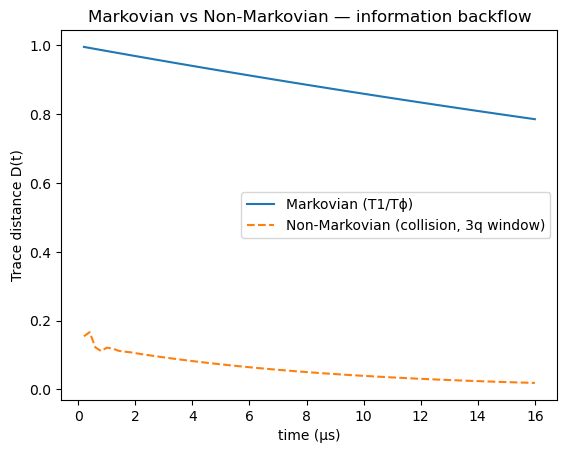

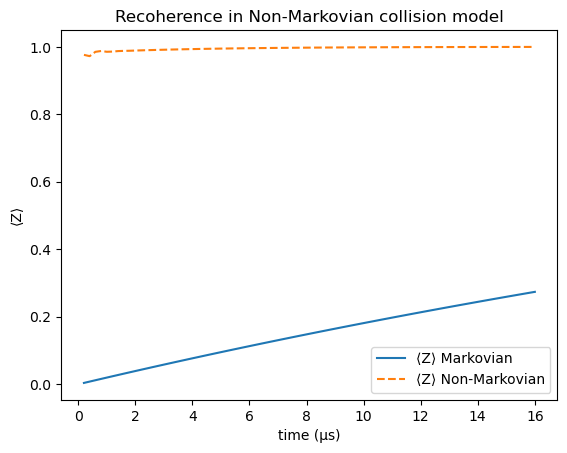

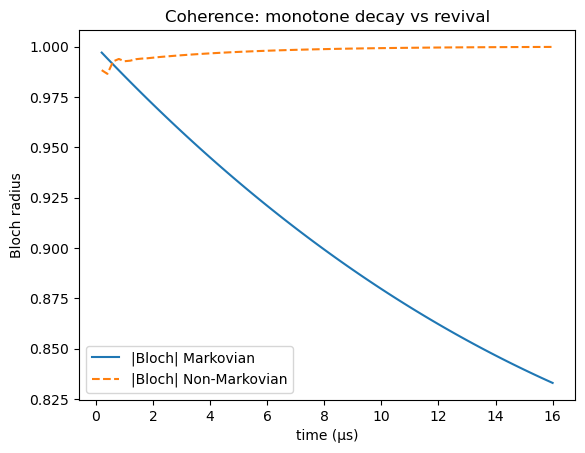

In [4]:
# === Compare Markovian (Aer T1/Tphi) vs Non-Markovian (collision, 3-qubit window) ===
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, phase_damping_error
from qiskit.quantum_info import DensityMatrix, partial_trace, Pauli

# ---------------------------
# Utilities
# ---------------------------
Xp, Yp, Zp = [Pauli(s).to_matrix() for s in "XYZ"]

def bloch_coords(rho):
    return (
        float(np.trace(rho @ Xp).real),
        float(np.trace(rho @ Yp).real),
        float(np.trace(rho @ Zp).real),
    )

def trace_distance(rho, sigma):
    # TD = 0.5 * ||rho - sigma||_1  (sum abs eigenvalues / 2 for Hermitian)
    w = np.linalg.eigvalsh(rho - sigma)
    return 0.5*float(np.sum(np.abs(w)))

# ---------------------------
# 1) Markovian baseline (Aer T1/Tphi) -- your working part stays
# ---------------------------
def simulate_markovian(T1=50e-6, Tphi=100e-6, dt=0.2e-6, N=80):
    p_ampl  = 1 - np.exp(-dt / T1)
    p_phase = 1 - np.exp(-dt / Tphi)

    noise = NoiseModel()
    ops = ['id','x','y','z','rx','ry','rz']
    noise.add_all_qubit_quantum_error(amplitude_damping_error(p_ampl), ops)
    noise.add_all_qubit_quantum_error(phase_damping_error(p_phase), ops)

    def build_circ(init='plus'):
        qc = QuantumCircuit(1)
        qc.h(0)
        if init == 'minus':
            qc.z(0)
        for k in range(N):
            qc.id(0)
            qc.save_density_matrix(label=f"rho_step_{k+1}")
        return qc

    qc_plus  = build_circ('plus')
    qc_minus = build_circ('minus')

    backend = AerSimulator(method='density_matrix')
    res_plus  = backend.run(qc_plus,  noise_model=noise, shots=1).result()
    res_minus = backend.run(qc_minus, noise_model=noise, shots=1).result()
    data_plus, data_minus = res_plus.data(0), res_minus.data(0)

    ts = dt * np.arange(1, N+1)
    bloch_plus, D = [], []
    for k in range(1, N+1):
        rho1 = DensityMatrix(data_plus [f"rho_step_{k}"]).data
        rho2 = DensityMatrix(data_minus[f"rho_step_{k}"]).data
        bloch_plus.append(bloch_coords(rho1))
        D.append(trace_distance(rho1, rho2))
    return ts, np.array(bloch_plus), np.array(D)

# ---------------------------
# 2) Non-Markovian collision (sliding 3-qubit window: S, C, N) -- pure NumPy
# ---------------------------
def simulate_collision_iterative(N_steps=80, theta=0.30, phi=0.55, dt=0.2e-6):
    # Pauli matrices
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    I2 = np.eye(2, dtype=complex)
    I4 = np.eye(4, dtype=complex)

    # Two-qubit gates: RXX and RYY
    def Rxx(a):
        return np.cos(a/2)*I4 - 1j*np.sin(a/2)*np.kron(X, X)
    def Ryy(a):
        return np.cos(a/2)*I4 - 1j*np.sin(a/2)*np.kron(Y, Y)
    def U_partial(a):  # partial-swap-like unitary
        return Rxx(a) @ Ryy(a)

    U_SC = U_partial(theta)   # acts on (S,C)
    U_CN = U_partial(phi)     # acts on (C,N)

    U_SC_full = np.kron(U_SC, I2)  # (S,C) ⊗ N
    U_CN_full = np.kron(I2, U_CN)  # S ⊗ (C,N)

    # basis states
    ket0 = np.array([[1.0],[0.0]], dtype=complex)
    ket1 = np.array([[0.0],[1.0]], dtype=complex)
    ketp = (ket0 + ket1)/np.sqrt(2)
    ketm = (ket0 - ket1)/np.sqrt(2)

    def evolve_branch(ket_init):
        # initial 3-qubit density: rho_S ⊗ |0><0|_C ⊗ |0><0|_N
        rhoS = ket_init @ ket_init.conj().T
        anc0 = ket0 @ ket0.conj().T
        rho = np.kron(np.kron(rhoS, anc0), anc0)   # 8x8

        bloch_list, rhos_sys, Ds_helper = [], [], []

        for _ in range(N_steps):
            # 1) S<->C collision
            rho = U_SC_full @ rho @ U_SC_full.conj().T
            # 2) C<->N correlation (seeds memory)
            rho = U_CN_full @ rho @ U_CN_full.conj().T

            # Record reduced system
            rho_full = DensityMatrix(rho, dims=(2,2,2))
            rhoS_now = partial_trace(rho_full, [1,2]).data   # trace out C,N
            bloch_list.append(bloch_coords(rhoS_now))
            rhos_sys.append(rhoS_now)

            # 3) Advance window: trace out old C, keep (S, N) -> append fresh |0> as new N
            rho_SN = partial_trace(rho_full, [1]).data       # keep [S,N] (order [0,2])
            rho = np.kron(rho_SN, anc0)                      # new 3-qubit state: [S, C(new)=old N, N(new)=|0>]

        return np.array(bloch_list), rhos_sys

    # Evolve |+> and |->
    bloch_p, rhos_p = evolve_branch(ketp)
    bloch_m, rhos_m = evolve_branch(ketm)

    # Trace-distance between the two reduced system trajectories
    D = np.array([trace_distance(rp, rm) for rp, rm in zip(rhos_p, rhos_m)])
    ts = dt * np.arange(1, N_steps+1)
    return ts, bloch_p, D

# ---------------------------
# Run both on the SAME time axis
# ---------------------------
dt   = 0.2e-6
N    = 80
T1   = 50e-6
Tphi = 100e-6

ts_M,  bloch_M,  D_M  = simulate_markovian(T1=T1, Tphi=Tphi, dt=dt, N=N)
ts_NM, bloch_NM, D_NM = simulate_collision_iterative(N_steps=N, theta=0.30, phi=0.55, dt=dt)

# ---------------------------
# Plots
# ---------------------------
plt.figure()
plt.plot(ts_M*1e6, D_M,  label='Markovian (T1/Tϕ)')
plt.plot(ts_NM*1e6, D_NM, label='Non-Markovian (collision, 3q window)', linestyle='--')
plt.xlabel('time (µs)'); plt.ylabel('Trace distance D(t)')
plt.title('Markovian vs Non-Markovian — information backflow')
plt.legend(); plt.show()

plt.figure()
plt.plot(ts_M*1e6, bloch_M[:,2],  label='⟨Z⟩ Markovian')
plt.plot(ts_NM*1e6, bloch_NM[:,2], label='⟨Z⟩ Non-Markovian', linestyle='--')
plt.xlabel('time (µs)'); plt.ylabel('⟨Z⟩')
plt.title('Recoherence in Non-Markovian collision model')
plt.legend(); plt.show()

r_M  = np.linalg.norm(bloch_M, axis=1)
r_NM = np.linalg.norm(bloch_NM, axis=1)
plt.figure()
plt.plot(ts_M*1e6, r_M,  label='|Bloch| Markovian')
plt.plot(ts_NM*1e6, r_NM, label='|Bloch| Non-Markovian', linestyle='--')
plt.xlabel('time (µs)'); plt.ylabel('Bloch radius')
plt.title('Coherence: monotone decay vs revival')
plt.legend(); plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, amplitude_damping_error, phase_damping_error
from qiskit.quantum_info import Pauli

# Pauli matrices (for Bloch coords)
X = Pauli('X').to_matrix()
Y = Pauli('Y').to_matrix()
Z = Pauli('Z').to_matrix()

def bloch_coords(rho: np.ndarray):
    return (float(np.trace(rho @ X).real),
            float(np.trace(rho @ Y).real),
            float(np.trace(rho @ Z).real))

def bloch_radius(rho: np.ndarray):
    bx, by, bz = bloch_coords(rho)
    return float(np.sqrt(bx*bx + by*by + bz*bz))

def trace_distance(rho: np.ndarray, sigma: np.ndarray):
    # 0.5 * ||rho - sigma||_1  (sum abs eigenvalues / 2 for Hermitian)
    w = np.linalg.eigvalsh(rho - sigma)
    return 0.5*float(np.sum(np.abs(w)))

def blp_backflow(D, eps=1e-10):
    inc = np.diff(np.asarray(D, float))
    inc[inc < eps] = 0.0
    return float(np.sum(inc))

def max_positive_increment(D, eps=1e-10):
    inc = np.diff(np.asarray(D, dtype=float))
    inc[inc < eps] = 0.0
    return float(np.max(np.concatenate(([0.0], inc))))

print("BLP Markovian:", blp_backflow(D_M))     # should be ~0
print("BLP Non-Markovian:", blp_backflow(D_NM))# should be >0 if backflow present
print("Max ΔD Markovian:", max_positive_increment(D_M))



BLP Markovian: 0.0
BLP Non-Markovian: 0.02191150208782776
Max ΔD Markovian: 0.0


In [6]:
def simulate_markovian(T1=50e-6, Tphi=100e-6, dt=0.2e-6, N=80):
    # Per-step error probabilities from continuous times
    p_ampl  = 1 - np.exp(-dt / T1)
    p_phase = 1 - np.exp(-dt / Tphi)

    # Compose once; attach ONLY to 'id' so Aer doesn’t warn about duplicates
    combo = amplitude_damping_error(p_ampl).compose(phase_damping_error(p_phase))
    noise = NoiseModel()
    noise.add_all_qubit_quantum_error(combo, ['id'])

    def circ(init='plus'):
        qc = QuantumCircuit(1)
        qc.h(0)
        if init == 'minus':
            qc.z(0)
        for k in range(N):
            qc.id(0)
            qc.save_density_matrix(label=f"rho_step_{k+1}")
        return qc

    backend = AerSimulator(method='density_matrix')
    res_p = backend.run(circ('plus'),  noise_model=noise, shots=1).result().data(0)
    res_m = backend.run(circ('minus'), noise_model=noise, shots=1).result().data(0)

    ts = dt*np.arange(1, N+1)
    bloch_p, D = [], []
    for k in range(1, N+1):
        rho1 = np.array(res_p[f"rho_step_{k}"], dtype=complex)
        rho2 = np.array(res_m[f"rho_step_{k}"], dtype=complex)
        bloch_p.append(bloch_coords(rho1))
        D.append(trace_distance(rho1, rho2))
    return ts, np.array(bloch_p), np.array(D)


In [7]:
# --- Non-Markovian (collision model) helpers: paste ABOVE your candidates block ---

import numpy as np

def U_partial(theta):
    """2-qubit partial-swap built from RXX and RYY."""
    X = np.array([[0,1],[1,0]], dtype=complex)
    Y = np.array([[0,-1j],[1j,0]], dtype=complex)
    I4 = np.eye(4, dtype=complex)
    Rxx = np.cos(theta/2)*I4 - 1j*np.sin(theta/2)*np.kron(X, X)
    Ryy = np.cos(theta/2)*I4 - 1j*np.sin(theta/2)*np.kron(Y, Y)
    return Rxx @ Ryy

def embed_adjacent(U2, start, nq):
    """Embed 2-qubit unitary U2 on adjacent pair (start,start+1) among nq qubits."""
    I2 = np.eye(2, dtype=complex)
    U = np.array([[1]], dtype=complex)
    q = 0
    while q < nq:
        if q == start:
            U = np.kron(U, U2); q += 2
        else:
            U = np.kron(U, I2); q += 1
    return U

def ptrace_qubits(rho, nq, trace_out):
    """Partial trace over listed qubit indices; rho is (2^nq x 2^nq)."""
    dims = [2]*nq
    arr = rho.reshape(dims + dims)        # [2]*n ⊗ [2]*n tensor
    for q in sorted(trace_out, reverse=True):
        arr = np.trace(arr, axis1=q, axis2=q+len(dims))
        dims.pop(q)
    d = 1
    for dd in dims: d *= dd
    return arr.reshape(d, d)

def simulate_nm_series(N_steps, mem_depth, theta, phi, alpha=None):
    """
    Sliding window with S + mem_depth ancillas.
    Each step: collide S<->A0 (theta); correlate A0<->A1, A1<->A2, ... (phi);
    record rho_S; drop A0; append |0>.
    Returns:
      D(t) for antipodal equator pair (alpha, alpha+π),
      traj_plus: rho_S trajectory for |+> (for Bloch plots).
    """
    if alpha is None:
        alpha = 0.0

    nq   = 1 + mem_depth
    USC  = embed_adjacent(U_partial(theta), start=0,   nq=nq)              # (S,A0)
    UAA  = [embed_adjacent(U_partial(phi), start=i+1, nq=nq) for i in range(mem_depth-1)]

    k0 = np.array([[1],[0]], dtype=complex)
    k1 = np.array([[0],[1]], dtype=complex)
    anc0 = k0 @ k0.conj().T

    def evolve(ket_init):
        rho = ket_init @ ket_init.conj().T
        for _ in range(mem_depth):
            rho = np.kron(rho, anc0)
        traj = []
        for _ in range(N_steps):
            rho = USC @ rho @ USC.conj().T
            for U in UAA:
                rho = U @ rho @ U.conj().T
            rhoS = ptrace_qubits(rho, nq, list(range(1, nq)))
            traj.append(rhoS)
            rho_dropA0 = ptrace_qubits(rho, nq, [1])
            rho = np.kron(rho_dropA0, anc0)
        return traj

    # antipodal equator pair for D(t)
    ket_a  = (k0 + np.exp(1j*alpha)*k1)/np.sqrt(2)
    ket_ap = (k0 - np.exp(1j*alpha)*k1)/np.sqrt(2)
    traj1 = evolve(ket_a)
    traj2 = evolve(ket_ap)
    D = np.array([trace_distance(r1, r2) for r1, r2 in zip(traj1, traj2)])

    # representative |+> branch
    traj_plus = evolve((k0 + k1)/np.sqrt(2))
    return D, traj_plus

def blp_backflow(D, eps=1e-10):
    """BLP backflow: sum of positive increases; ignore <eps jitters."""
    inc = np.diff(np.asarray(D, float))
    inc[inc < eps] = 0.0
    return float(np.sum(inc))

def scan_alpha_for_backflow(N, mem_depth, theta, phi,
                            alphas=None, eps=1e-10):
    """Find alpha that maximizes BLP for fixed (m,theta,phi). Always returns a fallback alpha."""
    if alphas is None:
        alphas = np.linspace(0, 2*np.pi, 24, endpoint=False)
    best_N = -1.0
    best_alpha = alphas[0]   # fallback so it's never None
    best_D = None
    for a in alphas:
        D, _ = simulate_nm_series(N_steps=N, mem_depth=mem_depth, theta=theta, phi=phi, alpha=a)
        N_blp = blp_backflow(D, eps)
        if (N_blp > best_N + 1e-12) or (best_D is None):
            best_N, best_alpha, best_D = N_blp, a, D
    return best_N, best_alpha, best_D


In [8]:
candidates = [
    # m,   theta,  phi     # comment
    (4,   0.20,   1.30),   # already good in your runs (BLP ~ 0.3)
    (5,   0.18,   1.35),   # stronger memory; usually clear bumps
    (5,   0.20,   1.40),   # very strong ancilla correlations
    (6,   0.18,   1.25),   # deeper memory, slightly gentler phi
    (6,   0.17,   1.30),   # deep memory + weak swap
    (5,   0.22,   1.20),   # moderate, still often >0 BLP
]

alphas = np.array([0, np.pi/6, np.pi/3, np.pi/2, 2*np.pi/3, 5*np.pi/6, 4*np.pi/3, 3*np.pi/2])
for m, th, ph in candidates:
    best_N, best_a, _ = scan_alpha_for_backflow(N=N, mem_depth=m, theta=th, phi=ph, alphas=alphas)
    print(f"m={m}, θ={th:.2f}, φ={ph:.2f} → BLP={best_N:.4g} at α={best_a}")



m=4, θ=0.20, φ=1.30 → BLP=0.3074 at α=0.0
m=5, θ=0.18, φ=1.35 → BLP=0 at α=0.0
m=5, θ=0.20, φ=1.40 → BLP=0 at α=0.0
m=6, θ=0.18, φ=1.25 → BLP=0.1837 at α=0.0
m=6, θ=0.17, φ=1.30 → BLP=0.1583 at α=0.0
m=5, θ=0.22, φ=1.20 → BLP=0 at α=0.0


m=4, θ=0.35, φ=0.55 → BLP = 0.1605 at α = 0.0


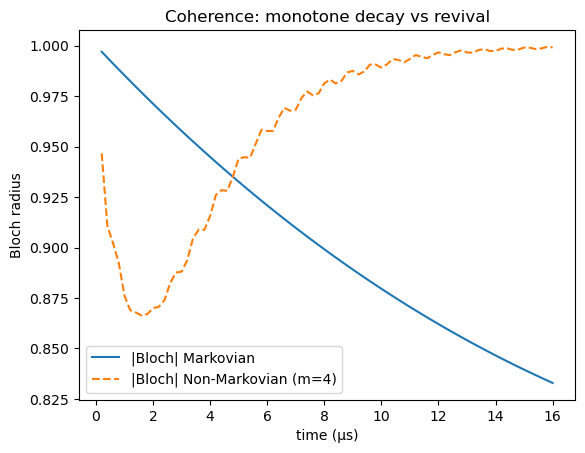

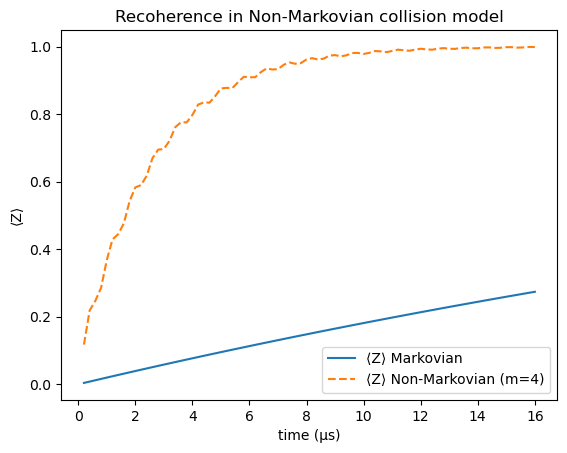

In [9]:


best_N, best_alpha, best_D = 0.0, None, None
for a in alphas:
    D_try, _ = simulate_nm_series(N_steps=N, mem_depth=mem_depth, theta=theta, phi=phi, alpha=a)
    N_blp = blp_backflow(D_try)
    if N_blp > best_N:
        best_N, best_alpha, best_D = N_blp, a, D_try

print(f"m={mem_depth}, θ={theta}, φ={phi} → BLP = {best_N:.4g} at α = {best_alpha}")



# safe fallback if no alpha gave BLP>0
if best_alpha is None:
    best_alpha = 0.0
D_NM, traj_plus = simulate_nm_series(N_steps=N, mem_depth=mem_depth, theta=theta, phi=phi, alpha=best_alpha)

Z_NM = np.array([bloch_coords(r)[2] for r in traj_plus])
r_NM = np.array([bloch_radius(r) for r in traj_plus])

ts = dt*np.arange(1, N+1)


r_M = np.linalg.norm(bloch_M, axis=1)
plt.figure()
plt.plot(ts*1e6, r_M,  label='|Bloch| Markovian')
plt.plot(ts*1e6, r_NM, '--', label=f'|Bloch| Non-Markovian (m={mem_depth})')
plt.xlabel('time (µs)'); plt.ylabel('Bloch radius')
plt.title('Coherence: monotone decay vs revival'); plt.legend(); plt.show()

plt.figure()
plt.plot(ts*1e6, [b[2] for b in bloch_M],  label='⟨Z⟩ Markovian')
plt.plot(ts*1e6, Z_NM, '--', label=f'⟨Z⟩ Non-Markovian (m={mem_depth})')
plt.xlabel('time (µs)'); plt.ylabel('⟨Z⟩')
plt.title('Recoherence in Non-Markovian collision model'); plt.legend(); plt.show()


In [16]:
# Get NM trajectory for the optimized equator state |ψ_α> (instead of |+>)
def nm_traj_for_alpha(N_steps, mem_depth, theta, phi, alpha):
    # uses your existing U_partial, embed_adjacent, ptrace_qubits
    nq   = 1 + mem_depth
    USC  = embed_adjacent(U_partial(theta), start=0,   nq=nq)
    UAA  = [embed_adjacent(U_partial(phi), start=i+1, nq=nq) for i in range(mem_depth-1)]

    k0 = np.array([[1],[0]], dtype=complex)
    k1 = np.array([[0],[1]], dtype=complex)
    anc0 = k0 @ k0.conj().T
    ket_a = (k0 + np.exp(1j*alpha)*k1)/np.sqrt(2)

    rho = ket_a @ ket_a.conj().T
    for _ in range(mem_depth):
        rho = np.kron(rho, anc0)

    traj = []
    for _ in range(N_steps):
        rho = USC @ rho @ USC.conj().T
        for U in UAA:
            rho = U @ rho @ U.conj().T
        rhoS = ptrace_qubits(rho, nq, list(range(1, nq)))
        traj.append(rhoS)
        rho_dropA0 = ptrace_qubits(rho, nq, [1])
        rho = np.kron(rho_dropA0, anc0)
    return traj

# After you’ve found best_alpha:
traj_alpha = nm_traj_for_alpha(N_steps=N, mem_depth=mem_depth, theta=theta, phi=phi, alpha=best_alpha)
Z_NM = np.array([bloch_coords(r)[2] for r in traj_alpha])
r_NM = np.array([np.linalg.norm(bloch_coords(r)) for r in traj_alpha])



Calibrated Markovian: T2_eff ≈ 3.50 µs  |  T1=50.0 µs  Tphi=3.6 µs
Crossings found: [(0.562, 'down'), (1.999, 'up')]


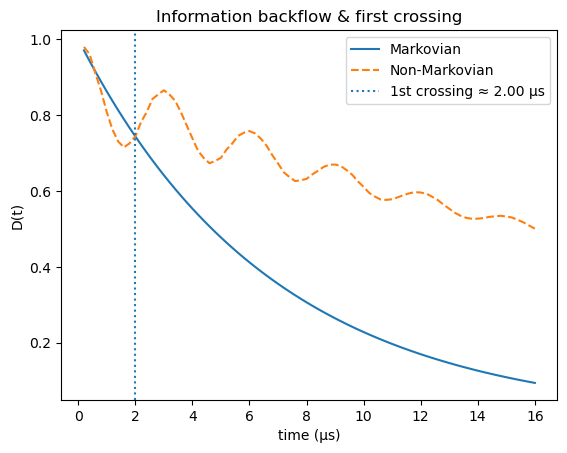

ValueError: 
D(t)=\frac{1}{2}\,\left\lVert \rho_1(t)-\rho_2(t)\right\rVert_{1}
                       ^
ParseSyntaxException: Expected a delimiter, found '\'  (at char 23), (line:1, col:24)

<Figure size 640x480 with 1 Axes>

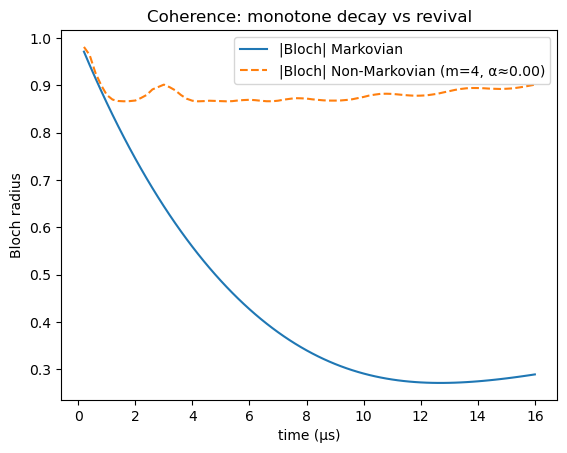

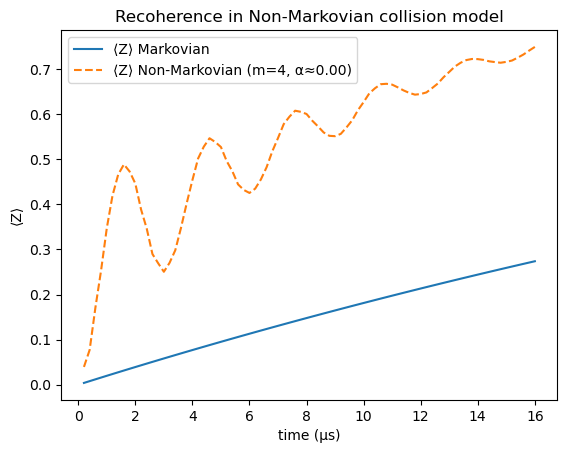

In [25]:
# ---------- Choose a strong NM set (from your scan) ----------
mem_depth = 4
theta     = 0.20
phi       = 1.30
alpha     = 0.0   # your scan already found this best for the set above

# Run NM once
D_NM, traj_plus = simulate_nm_series(N_steps=N, mem_depth=mem_depth,
                                     theta=theta, phi=phi, alpha=alpha)

# ---------- Fit an effective Markovian T2 from early-time NM decay ----------
def fit_T2_from_series(D, dt, k_fit=5):
    """
    Fit ln D(t) ~ -t/T2 using the first k_fit points (excluding t=0).
    Returns T2_eff (>0). If D has plateaus, increase k_fit.
    """
    t = dt * np.arange(1, min(k_fit, len(D)))     # times for k=1..k_fit-1
    y = np.log(np.maximum(1e-15, D[1:1+len(t)]))  # avoid log(0)
    # linear fit y = a + b t  => T2 = -1/b
    b = np.polyfit(t, y, 1)[0]
    return max(1e-12, -1.0/b)

T2_eff = fit_T2_from_series(D_NM, dt, k_fit=5)

# Pick a T1 and solve for Tphi via 1/T2 = 1/(2T1) + 1/Tphi
T1_target = 50e-6  # keep your earlier scale; you can also set huge T1 to make pure dephasing
inv_Tphi = (1.0/T2_eff) - (1.0/(2.0*T1_target))
if inv_Tphi <= 0:
    # fallback: make it pure dephasing by using a very long T1 and Tphi = T2_eff
    T1_use  = 1e9
    Tphi_use = T2_eff
else:
    T1_use  = T1_target
    Tphi_use = 1.0/inv_Tphi

print(f"Calibrated Markovian: T2_eff ≈ {T2_eff*1e6:.2f} µs  |  T1={T1_use*1e6:.1f} µs  Tphi={Tphi_use*1e6:.1f} µs")

# ---------- Run Markovian with calibrated (T1,Tphi) ----------
ts_M, bloch_M, D_M = simulate_markovian(T1=T1_use, Tphi=Tphi_use, dt=dt, N=N)

# ---------- Find and display crossings ----------
ts = dt*np.arange(1, N+1)

# Markovian must also be re-run if you changed T1/Tphi:
ts_M, bloch_M, D_M = simulate_markovian(T1=T1_use, Tphi=Tphi_use, dt=dt, N=N)
r_M  = np.linalg.norm(bloch_M, axis=1)


def find_crossings(ts, D_NM, D_M, eps=1e-12):
    """Return [(t_cross, direction)], direction=+1 (NM rises above M) or -1 (falls below)."""
    ts = np.asarray(ts, float)
    diff = np.asarray(D_NM, float) - np.asarray(D_M, float)
    # treat tiny differences as zero to avoid jitter
    diff[np.abs(diff) < eps] = 0.0

    signs = np.sign(diff)
    # indices where sign changes (exclude zero-to-zero)
    idx_changes = np.where(np.diff(signs) != 0)[0]
    crossings = []
    for i in idx_changes:
        # linear interpolation between (ts[i], diff[i]) and (ts[i+1], diff[i+1])
        d0, d1 = diff[i], diff[i+1]
        t0, t1 = ts[i], ts[i+1]
        if d1 == d0:  # degenerate; skip
            continue
        frac = -d0 / (d1 - d0)
        if 0.0 <= frac <= 1.0:
            t_cross = t0 + frac*(t1 - t0)
            direction = 1 if d0 < 0 and d1 > 0 else -1
            crossings.append((t_cross, direction))
        
    return crossings

crossings = find_crossings(ts, D_NM, D_M, eps=1e-12)
print("Crossings found:", [(round(t*1e6,3), "up" if d>0 else "down") for t,d in crossings])

# First crossing time (if any):
first_up = next(((t,d) for t,d in crossings if d>0), None)
if first_up:
    t1 = first_up[0]
    plt.figure()
    plt.plot(ts*1e6, D_M,  label='Markovian')
    plt.plot(ts*1e6, D_NM, '--', label='Non-Markovian')
    plt.axvline(t1*1e6, linestyle=':', label=f'1st crossing ≈ {t1*1e6:.2f} µs')
    plt.xlabel('time (µs)'); plt.ylabel('D(t)')
    plt.legend(); plt.title('Information backflow & first crossing'); plt.show()

else:
    print("No upward crossing detected.")



# AFTER plotting D_M and D_NM:
lbl_M  = rf"Markovian: $T_1={T1_use*1e6:.0f}\,\mu s$, $T_\phi={Tphi_use*1e6:.1f}\,\mu s$"
lbl_NM = rf"Non-Markovian: $m={mem_depth}$, $\theta={theta:.2f}$, $\phi={phi:.2f}$, $\mathcal{{N}}_\mathrm{{BLP}}={best_N:.3g}$"
plt.legend([lbl_M, lbl_NM], loc="upper right", fontsize=9)

# Little formula box inside axes
eq_box = (
    r"$D(t)=\frac{1}{2}\,\left\lVert \rho_1(t)-\rho_2(t)\right\rVert_{1}$" "\n"
    r"Markovian: $\dot{\rho}=-i[H_S,\rho]+\gamma_1\,\mathcal{D}[\sigma_-]\rho+\gamma_{\phi}\,\mathcal{D}[\sigma_z]\rho$"
)
ax = plt.gca()
ax.text(0.02, 0.02, eq_box, transform=ax.transAxes, fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7", alpha=0.85))



# Optional: highlight backflow steps too
def blp_backflow(D, eps=1e-10):
    inc = np.diff(np.asarray(D, float))
    inc[inc < eps] = 0.0
    return float(np.sum(inc))
eps = 1e-10
mask_backflow = np.diff(D_NM) > eps

ts = dt*np.arange(1, N+1)

r_M = np.linalg.norm(bloch_M, axis=1)

plt.figure()
plt.plot(ts*1e6, r_M,  label='|Bloch| Markovian')
plt.plot(ts*1e6, r_NM, '--', label=f'|Bloch| Non-Markovian (m={mem_depth}, α≈{best_alpha:.2f})')
plt.xlabel('time (µs)'); plt.ylabel('Bloch radius'); plt.title('Coherence: monotone decay vs revival'); plt.legend(); plt.show()

plt.figure()
plt.plot(ts*1e6, [b[2] for b in bloch_M],  label='⟨Z⟩ Markovian')
plt.plot(ts*1e6, Z_NM, '--', label=f'⟨Z⟩ Non-Markovian (m={mem_depth}, α≈{best_alpha:.2f})')
plt.xlabel('time (µs)'); plt.ylabel('⟨Z⟩'); plt.title('Recoherence in Non-Markovian collision model'); plt.legend(); plt.show()





In [22]:
# Build NM Bloch coords once
bloch_NM = np.array([bloch_coords(r) for r in traj_plus])
r_NM     = np.linalg.norm(bloch_NM, axis=1)
Z_NM     = bloch_NM[:, 2]

# Markovian Bloch radius
r_M  = np.linalg.norm(bloch_M, axis=1)

# BLP for legend
BLP_NM = blp_backflow(D_NM)


In [24]:
fig, ax = plt.subplots()
lbl_M  = rf"Markovian: $T_1={T1_use*1e6:.0f}\,\mu s$, $T_\phi={Tphi_use*1e6:.1f}\,\mu s$"
lbl_NM = rf"Non-Markovian: $m={mem_depth}$, $\theta={theta:.2f}$, $\phi={phi:.2f}$, $\mathcal{{N}}_\mathrm{{BLP}}={BLP_NM:.3g}$"

ax.plot(ts*1e6, D_M,  label=lbl_M)
ax.plot(ts*1e6, D_NM, '--', label=lbl_NM)

# optional: first crossing marker
crossings = find_crossings(ts, D_NM, D_M, eps=1e-12)
first_up = next(((t,d) for t,d in crossings if d>0), None)
if first_up:
    ax.axvline(first_up[0]*1e6, linestyle=':', label=f'1st crossing ≈ {first_up[0]*1e6:.2f} µs')

ax.set_xlabel('time (µs)'); ax.set_ylabel('D(t)')
ax.set_title('Information backflow & first crossing')
ax.legend(loc='upper right', fontsize=9)

eq_box = (
    r"$D(t)=\frac{1}{2}\,\left\lVert \rho_1(t)-\rho_2(t)\right\rVert_{1}$" "\n"
    r"Markovian: $\dot{\rho}=-i[H_S,\rho]+\gamma_1\,\mathcal{D}[\sigma_-]\rho+\gamma_{\phi}\,\mathcal{D}[\sigma_z]\rho$"
)
ax = plt.gca()
ax.text(0.02, 0.02, eq_box, transform=ax.transAxes, fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.7", alpha=0.85))

plt.show()


ValueError: 
D(t)=\frac{1}{2}\,\left\lVert \rho_1(t)-\rho_2(t)\right\rVert_{1}
                       ^
ParseSyntaxException: Expected a delimiter, found '\'  (at char 23), (line:1, col:24)

<Figure size 640x480 with 1 Axes>

In [12]:
# --- Bloch sphere plotter (3D) ---
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # (import side-effect for 3D)

def plot_bloch_sphere(trajs_xyz, labels=None, title="Bloch sphere with trajectories"):
    """
    trajs_xyz: list of arrays, each shape (T,3) with columns (bx, by, bz)
    labels:    list of legend labels, same length as trajs_xyz
    """
    if labels is None:
        labels = [f"traj {i}" for i in range(len(trajs_xyz))]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # --- Sphere surface (unit radius) ---
    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_surface(xs, ys, zs, rstride=3, cstride=3, alpha=0.08, linewidth=0)

    # Equator + axes
    t = np.linspace(0, 2*np.pi, 200)
    ax.plot(np.cos(t), np.sin(t), 0*t, lw=0.8, alpha=0.6)          # equator
    ax.plot([-1,1],[0,0],[0,0], lw=0.8, alpha=0.6)                 # X
    ax.plot([0,0],[-1,1],[0,0], lw=0.8, alpha=0.6)                 # Y
    ax.plot([0,0],[0,0],[-1,1], lw=0.8, alpha=0.6)                 # Z

    # --- Trajectories ---
    for arr, lab in zip(trajs_xyz, labels):
        arr = np.asarray(arr, float)
        ax.plot(arr[:,0], arr[:,1], arr[:,2], label=lab, lw=2)
        # start/end markers
        ax.scatter(arr[0,0],  arr[0,1],  arr[0,2],  s=40, marker='o')
        ax.scatter(arr[-1,0], arr[-1,1], arr[-1,2], s=40, marker='^')

    # Formatting
    ax.set_xlim(-1,1); ax.set_ylim(-1,1); ax.set_zlim(-1,1)
    ax.set_box_aspect([1,1,1])
    ax.set_xlabel('⟨X⟩'); ax.set_ylabel('⟨Y⟩'); ax.set_zlabel('⟨Z⟩')
    ax.set_title(title)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0))
    plt.tight_layout()
    plt.show()


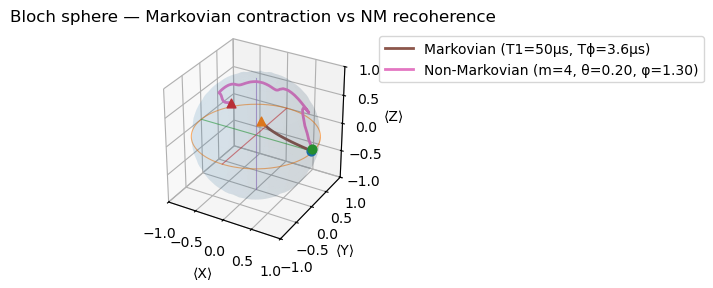

In [15]:
# If you used traj_plus (|+> branch) for NM:
#bloch_NM_xyz = np.array([bloch_coords(r) for r in traj_plus])

# If you prefer the optimized-α trajectory instead:
traj_alpha = nm_traj_for_alpha(N_steps=N, mem_depth=mem_depth, theta=theta, phi=phi, alpha=best_alpha)
bloch_NM_xyz = np.array([bloch_coords(r) for r in traj_alpha])
plot_bloch_sphere(
    trajs_xyz=[bloch_M, bloch_NM_xyz],
    labels=[f"Markovian (T1={T1_use*1e6:.0f}µs, Tϕ={Tphi_use*1e6:.1f}µs)",
            f"Non-Markovian (m={mem_depth}, θ={theta:.2f}, φ={phi:.2f})"],
    title="Bloch sphere — Markovian contraction vs NM recoherence"
)



In [2]:
import numpy as np
from scipy.linalg import expm

# --- ASSUMED SYSTEM PARAMETERS ---
N_BATH = 3  # Number of bath spins (must be small for explicit density matrix)
D_HILBERT = 2**N_BATH  # Dimension of the Hilbert space (e.g., 8 for N=3)
DT = 0.01  # Time step (Trotter step size)

# Assume H is the total Hamiltonian matrix (D x D) for the spin bath.
# This H includes NV-bath coupling and bath-bath interactions.
# H = np.array(...) 

# --- STEP 1: DEFINE OBSERVABLE (e.g., the coherence of the central NV spin) ---

def calculate_coherence(rho):
    """
    Measures the Z-coherence (or magnetization) of the first bath spin.
    In a full simulation, this would measure the central NV spin's coherence.
    """
    # Example: Calculate Tr(rho * Sigma_Z_0) where Sigma_Z_0 is the Pauli-Z 
    # operator acting on the first bath spin (qubit 0).
    sigma_z_0 = np.kron(np.diag([1, -1]), np.eye(2**(N_BATH - 1)))
    coherence = np.trace(rho @ sigma_z_0).real
    return coherence

# --- STEP 2: IMPLEMENT QUANTUM TIME EVOLUTION ---

def quantum_time_evolution(H, initial_rho, num_steps, dt):
    """
    Performs time evolution on the density matrix using the exact matrix exponential.
    For larger systems, this step would be replaced by Trotterization 
    or a specialized solver (like ED/TN).
    """
    rho = initial_rho
    coherence_history = [calculate_coherence(rho)]
    
    # Calculate the time evolution operator for one step (U_dt = exp(-i*H*dt))
    U_dt = expm(-1j * H * dt)
    U_dt_dag = U_dt.conj().T
    
    for _ in range(num_steps):
        # Time evolution of the density matrix: ρ(t+dt) = U_dt * ρ(t) * U_dt†
        rho = U_dt @ rho @ U_dt_dag
        
        # Store the observable
        coherence_history.append(calculate_coherence(rho))
        
    return np.array(coherence_history)

# --- STEP 3: EXECUTION (Requires defined H and initial_rho) ---
# Example H (placeholder for 3 spins, showing coupling terms)
# H = (J12 * I1x I2x) + (A_NV1 * I1z S_NV_z) + ... 
# (In a real scenario, H would be built from the NV-center model)
# For the demo, let H be a random Hermitian matrix:
H_placeholder = np.random.rand(D_HILBERT, D_HILBERT)
H_placeholder = (H_placeholder + H_placeholder.T.conj()) * 10 

# Initial state: Maximally mixed state (ρ_mm = I / D)
initial_rho = np.eye(D_HILBERT) / D_HILBERT

# Run the simulation for 100 steps
coherence_trace = quantum_time_evolution(
    H_placeholder, 
    initial_rho, 
    num_steps=100, 
    dt=DT
)

print(coherence_trace) 
# The results would then be compared against classical/semi-classical runs.

[ 0.00000000e+00  4.16333634e-17  8.32667268e-17  1.24900090e-16
  1.52655666e-16  1.66533454e-16  1.80411242e-16  1.94289029e-16
  2.08166817e-16  2.49800181e-16  3.05311332e-16  3.33066907e-16
  3.60822483e-16  3.60822483e-16  3.60822483e-16  3.60822483e-16
  3.88578059e-16  4.44089210e-16  4.99600361e-16  5.55111512e-16
  5.55111512e-16  4.71844785e-16  4.16333634e-16  3.88578059e-16
  3.60822483e-16  3.05311332e-16  3.05311332e-16  3.05311332e-16
  3.05311332e-16  2.22044605e-16  1.66533454e-16  1.11022302e-16
  1.11022302e-16  5.55111512e-17  0.00000000e+00  2.77555756e-17
  1.38777878e-16  2.22044605e-16  2.22044605e-16  1.94289029e-16
  1.66533454e-16  1.11022302e-16  1.66533454e-16  2.77555756e-16
  3.60822483e-16  4.44089210e-16  4.44089210e-16  4.16333634e-16
  4.44089210e-16  3.88578059e-16  3.05311332e-16  2.77555756e-16
  2.22044605e-16  2.49800181e-16  3.33066907e-16  3.88578059e-16
  4.44089210e-16  4.44089210e-16  4.16333634e-16  3.60822483e-16
  3.33066907e-16  3.33066